In [2]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('secret.csv')
df = df.drop(columns=['id','best lap','last lap'])  
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')
df['timestamp'] -=df['timestamp'][0] 

# Display the DataFrame
df.head()
df['abs_pos_x'] = (df['pos_x']- df['pos_x'][0]  ).abs()
df['abs_pos_y'] = (df['pos_y']- df['pos_y'][0]  ).abs()
df['abs_pos_z'] = (df['pos_z']- df['pos_z'][0]  ).abs()

#create a column for total distance travelled from start of pos_x and pos_y and pos_z
df['total_distance'] = (df['abs_pos_x']**2 + df['abs_pos_y']**2 + df['abs_pos_z']**2)**0.5  


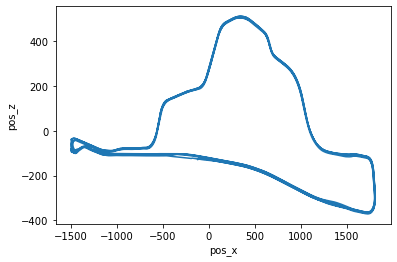

In [3]:
#plot pos_x vs pos_z 
import matplotlib.pyplot as plt
df1 =df [::10]
plt.plot(df1['pos_x'], df1['pos_z'])
plt.xlabel('pos_x')
plt.ylabel('pos_z')

plt.show()



In [4]:
df.columns

Index(['tick', 'timestamp', 'speed_kmh', 'pos_x', 'pos_y', 'pos_z', 'throttle',
       'brake', 'rpm', 'fuel', 'fuel capacity', 'packet id', 'curr',
       'gear_curr', 'gear_sugg', 'charge_rem', 'battery_max', 'boost',
       'tyre_diam_fl', 'tyre_diam_fr', 'tyre_diam_rl', 'tyre_diam_rr',
       'tyre_speed_fl', 'tyre_speed_fr', 'tyre_speed_rl', 'tyre_speed_rr',
       'time_of_day_ms', 'laps_total', 'positions_curr', 'positions_total',
       'rpm_warning', 'rpm_rev_limiter', 'speed_top', 'clutch',
       'clutch_engaged', 'rpm_after_clutch', 'oil_temp', 'water_temp',
       'oil_pressure', 'ride_height', 'tyre_temp_fl', 'tyre_temp_fr',
       'suspension_fl', 'suspension_fr', 'tyre_temp_rl', 'tyre_temp_rr',
       'suspension_rl', 'suspension_rr', 'gear_1', 'gear_2', 'gear_3',
       'gear_4', 'gear_5', 'gear_6', 'gear_7', 'gear_8', 'gear_9', 'vel_x',
       'vel_y', 'vel_z', 'rot_x', 'rot_y', 'rot_z', 'vel_ang_x', 'vel_ang_y',
       'vel_ang_z', 'rotx_x', 'unknown_bits_0', 'unknow

In [5]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial.distance import euclidean

def equidistant_track_representation(df, num_points=100):
    # Filter data for the first lap
    first_lap = df[df['laps_total'] == 1].copy()
    
    # Sort by timestamp to ensure proper order
    first_lap = first_lap.sort_values('timestamp')
    
    # Extract position data
    positions = first_lap[['pos_x', 'pos_z']].values
    
    # Calculate cumulative distance along the track
    distances = [0]
    for i in range(1, len(positions)):
        distances.append(distances[-1] + euclidean(positions[i-1], positions[i]))
    
    # Create interpolation functions for x and z coordinates
    total_distance = distances[-1]
    f_x = interp1d(distances, positions[:, 0], kind='linear')
    f_z = interp1d(distances, positions[:, 1], kind='linear')
    
    # Generate equidistant points
    equidistant_distances = np.linspace(0, total_distance, num_points)
    equidistant_positions = np.column_stack((f_x(equidistant_distances), f_z(equidistant_distances)))
    
    return equidistant_positions

# Assuming 'df' is your DataFrame
equidistant_track = equidistant_track_representation(df)

# Create a new DataFrame with the equidistant track representation
equidistant_df = pd.DataFrame(equidistant_track, columns=['pos_x', 'pos_z'])

ValueError: x and y arrays must be equal in length along interpolation axis.

In [48]:
import numpy as np

# Calculate the step-by-step Euclidean distance between consecutive points
df['distance_step'] = np.sqrt(
    (df['pos_x'].diff())**2 + 
    (df['pos_y'].diff())**2 + 
    (df['pos_z'].diff())**2
).fillna(0)  # Fill NaN for the first row

# Compute cumulative distance from the start of the lap
df['cumulative_distance'] = df['distance_step'].cumsum()

# Preview the data
print(df[['pos_x', 'pos_y', 'pos_z', 'distance_step', 'cumulative_distance']].tail())


           pos_x      pos_y      pos_z  distance_step  cumulative_distance
53107  217.37340 -19.172590 -141.59235       1.086348         37131.391914
53108  218.45189 -19.138370 -141.71095       1.085531         37132.477445
53109  219.52963 -19.103687 -141.82964       1.084810         37133.562255
53110  220.60661 -19.068405 -141.94840       1.084082         37134.646338
53111  221.68286 -19.032630 -142.06721       1.083379         37135.729716


In [49]:
# Set a threshold for detecting the start/finish line crossing (in meters)
threshold = 20.0  # Adjust this if needed

# Get the coordinates of the starting point
start_x = df['pos_x'].iloc[0]
start_z = df['pos_z'].iloc[0]

# Calculate the distance from the current position to the starting point
df['distance_to_start'] = np.sqrt((df['pos_x'] - start_x)**2 + (df['pos_z'] - start_z)**2)

# Detect when the car crosses the start/finish line (when distance is within the threshold)
df['lap_crossing'] = (df['distance_to_start'] < threshold)  # True when within threshold

# Identify the points where a new lap begins (from False to True transitions)
df['lap_change'] = df['lap_crossing'].astype(int).diff().fillna(0)

# Count the number of completed laps (each +1 transition indicates a new lap)
df['lap_number'] = df['lap_change'].clip(lower=0).cumsum()

# Preview the results
print(df[['pos_x', 'pos_z', 'distance_to_start', 'lap_number']].tail())


           pos_x      pos_z  distance_to_start  lap_number
53107  217.37340 -141.59235         338.946514         5.0
53108  218.45189 -141.71095         340.028841         5.0
53109  219.52963 -141.82964         341.110439         5.0
53110  220.60661 -141.94840         342.191297         5.0
53111  221.68286 -142.06721         343.271444         5.0


In [83]:
df.tail(20)

,tick,timestamp,speed_kmh,pos_x,pos_y,pos_z,throttle,brake,rpm,fuel,...,abs_pos_x,abs_pos_y,abs_pos_z,total_distance,distance_step,cumulative_distance,distance_to_start,lap_crossing,lap_change,lap_number
53092,53092,0 days 00:14:46.227221182,236.88918,201.09848,-19.618206,-139.82315,0,0,5206.0,68.78296,...,322.40969,0.378389,11.55276,322.616828,1.098077,37115.014986,322.616606,False,0.0,5.0
53093,53093,0 days 00:14:46.275939742,236.71964,202.18910,-19.593256,-139.94064,0,0,5203.0,68.78296,...,323.50031,0.403339,11.67025,323.710995,1.097214,37116.112199,323.710743,False,0.0,5.0
53094,53094,0 days 00:14:46.304869553,236.55505,203.27892,-19.567444,-140.05817,0,0,5199.0,68.78296,...,324.59013,0.429151,11.78778,324.804385,1.096443,37117.208642,324.804101,False,0.0,5.0
53095,53095,0 days 00:14:46.319359386,236.38908,204.36797,-19.541021,-140.17578,0,0,5195.0,68.78296,...,325.67918,0.455574,11.90539,325.897030,1.095701,37118.304343,325.896712,False,0.0,5.0
53096,53096,0 days 00:14:46.324832448,236.22563,205.45620,-19.514076,-140.29338,0,0,5191.0,68.78296,...,326.76741,0.482519,12.02299,326.988876,1.094897,37119.399241,326.988520,False,0.0,5.0
53097,53097,0 days 00:14:46.379790464,236.05692,206.54356,-19.486633,-140.41110,0,0,5187.0,68.78296,...,327.85477,0.509962,12.14071,328.079879,1.094058,37120.493299,328.079483,False,0.0,5.0
53098,53098,0 days 00:14:46.387892983,235.89127,207.63019,-19.458284,-140.52887,0,0,5183.0,68.78296,...,328.94140,0.538311,12.25848,329.170176,1.093361,37121.586660,329.169736,False,0.0,5.0
53099,53099,0 days 00:14:46.388099439,235.72363,208.71608,-19.429260,-140.64671,0,0,5179.0,68.78296,...,330.02729,0.567335,12.37632,330.259757,1.092651,37122.679310,330.259270,False,0.0,5.0
53100,53100,0 days 00:14:46.388226527,235.55719,209.80115,-19.399600,-140.76459,0,0,5176.0,68.78296,...,331.11236,0.596995,12.49420,331.348542,1.091857,37123.771168,331.348004,False,0.0,5.0
53101,53101,0 days 00:14:46.401124803,235.38487,210.88533,-19.369177,-140.88260,0,0,5173.0,68.78296,...,332.19654,0.627418,12.61221,332.436464,1.091008,37124.862176,332.435872,False,0.0,5.0


In [6]:
df.columns

Index(['tick', 'timestamp', 'speed_kmh', 'pos_x', 'pos_y', 'pos_z', 'throttle',
       'brake', 'rpm', 'fuel', 'fuel capacity', 'packet id', 'curr',
       'gear_curr', 'gear_sugg', 'charge_rem', 'battery_max', 'boost',
       'tyre_diam_fl', 'tyre_diam_fr', 'tyre_diam_rl', 'tyre_diam_rr',
       'tyre_speed_fl', 'tyre_speed_fr', 'tyre_speed_rl', 'tyre_speed_rr',
       'time_of_day_ms', 'laps_total', 'positions_curr', 'positions_total',
       'rpm_warning', 'rpm_rev_limiter', 'speed_top', 'clutch',
       'clutch_engaged', 'rpm_after_clutch', 'oil_temp', 'water_temp',
       'oil_pressure', 'ride_height', 'tyre_temp_fl', 'tyre_temp_fr',
       'suspension_fl', 'suspension_fr', 'tyre_temp_rl', 'tyre_temp_rr',
       'suspension_rl', 'suspension_rr', 'gear_1', 'gear_2', 'gear_3',
       'gear_4', 'gear_5', 'gear_6', 'gear_7', 'gear_8', 'gear_9', 'vel_x',
       'vel_y', 'vel_z', 'rot_x', 'rot_y', 'rot_z', 'vel_ang_x', 'vel_ang_y',
       'vel_ang_z', 'rotx_x', 'unknown_bits_0', 'unknow

In [7]:
df["cumulative_distance"]

KeyError: 'cumulative_distance'

In [50]:
#plot cumulative distance wth plotly line plot
import plotly.express as px
fig = px.line(df[::100], x='tick', y='cumulative_distance')
fig.show()


In [9]:
#plot distance_to_start vs tick with plotly line plot
fig = px.line(df, x='tick', y='distance_to_start')
fig.show()


NameError: name 'px' is not defined

In [10]:
# # Step 2: Calculate the total distance for each lap
# lap_distances = []

# for lap in df['lap_number'].unique():
#     # Extract the data for the current lap
#     lap_data = df[df['lap_number'] == lap].copy()

#     # Calculate the stepwise distance for this lap
#     lap_data['distance_step'] = np.sqrt(
#         (lap_data['pos_x'].diff())**2 +
#         (lap_data['pos_y'].diff())**2 +
#         (lap_data['pos_z'].diff())**2
#     ).fillna(0)

#     # Calculate the total distance for the lap except the last lap (which is incomplete)
#     lap_distance = lap_data['distance_step'].sum()
#     lap_distances.append(lap_distance)

# # Display the total distance for each lap
# print(lap_distances)
# # Step 3: Calculate the average lap distance excluding the incomplete lap
# average_lap_distance = sum(lap_distances[:-1]) / len(lap_distances[:-1])
# print(average_lap_distance)


In [11]:
#print unique values of curr
print(df['curr'].unique())


[0 1 2 3 4 5 6]


In [12]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial.distance import euclidean

def precise_equidistant_track_sampling_3d(df, ds=1):
    # Filter data for the first lap
    first_lap = df[df['curr'] == 0].copy()
    
    # Sort by timestamp to ensure proper order
    first_lap = first_lap.sort_values('timestamp')
    
    # Extract 3D position data
    positions = first_lap[['pos_x', 'pos_y', 'pos_z']].values
    
    # Calculate cumulative distance along the 3D track
    distances = [0]
    for i in range(1, len(positions)):
        distances.append(distances[-1] + euclidean(positions[i-1], positions[i]))
    
    # Create interpolation functions for x, y, and z coordinates
    total_distance = distances[-1]
    f_x = interp1d(distances, positions[:, 0], kind='linear')
    f_y = interp1d(distances, positions[:, 1], kind='linear')
    f_z = interp1d(distances, positions[:, 2], kind='linear')
    
    # Generate precisely equidistant points
    num_points = int(np.floor(total_distance / ds))
    equidistant_distances = np.arange(0, num_points * ds, ds)
    
    equidistant_positions = np.column_stack((
        f_x(equidistant_distances),
        f_y(equidistant_distances),
        f_z(equidistant_distances)
    ))
    
    # Add the last point if it's not too close to the previous point
    if total_distance - equidistant_distances[-1] > ds / 2:
        last_point = np.array([f_x(total_distance), f_y(total_distance), f_z(total_distance)])
        equidistant_positions = np.vstack((equidistant_positions, last_point))
    
    return equidistant_positions

# Assuming 'df' is your DataFrame
sampled_track = precise_equidistant_track_sampling_3d(df, ds=1)

# Create a new DataFrame with the sampled track representation
sampled_df = pd.DataFrame(sampled_track, columns=['pos_x', 'pos_y', 'pos_z'])

# Print the first few rows of the sampled track representation
print(sampled_df.head())

# Optionally, save the sampled track representation to a CSV file
sampled_df.to_csv('precisely_sampled_track_3d.csv', index=False)

# Print the total number of sampled points
print(f"Total number of sampled points: {len(sampled_df)}")

# Calculate and print the actual 3D distances between consecutive points
distances = np.sqrt(np.sum(np.diff(sampled_df.values, axis=0)**2, axis=1))
print("Statistics of 3D distances between consecutive points:")
print(f"Min: {distances.min():.6f}")
print(f"Max: {distances.max():.6f}")
print(f"Mean: {distances.mean():.6f}")
print(f"Std: {distances.std():.6f}")

# Calculate and print the total track length
print(f"Total 3D track length: {distances.sum():.2f}")

        pos_x      pos_y       pos_z
0 -121.311210 -19.996595 -128.270390
1 -120.432388 -19.995487 -127.793241
2 -119.553566 -19.994378 -127.316092
3 -118.674744 -19.993270 -126.838944
4 -117.795923 -19.992161 -126.361795
Total number of sampled points: 23
Statistics of 3D distances between consecutive points:
Min: 0.988993
Max: 1.376253
Mean: 1.016602
Std: 0.078516
Total 3D track length: 22.37


In [58]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial.distance import euclidean

def precise_equidistant_track_sampling_3d(df, ds=1):
    # Filter data for the first lap
    first_lap = df[df['curr'] == 0].copy()
    
    # Sort by timestamp to ensure proper order
    first_lap = first_lap.sort_values('timestamp')
    
    # Extract 3D position data
    try:
        positions = first_lap[['pos_x', 'pos_y', 'pos_z']].values
    except KeyError as e:
        print(f"Error: Missing column in DataFrame. {e}")
        print("Available columns:", df.columns)
        return None

    if len(positions) < 2:
        print("Error: Not enough data points for interpolation.")
        return None

    # Calculate cumulative distance along the 3D track
    distances = [0]
    for i in range(1, len(positions)):
        distances.append(distances[-1] + euclidean(positions[i-1], positions[i]))

    # Create interpolation functions for x, y, and z coordinates
    total_distance = distances[-1]
    
    try:
        f_x = interp1d(distances, positions[:, 0], kind='linear')
        f_y = interp1d(distances, positions[:, 1], kind='linear')
        f_z = interp1d(distances, positions[:, 2], kind='linear')
    except ValueError as e:
        print(f"Error during interpolation: {e}")
        print("distances shape:", np.shape(distances))
        print("positions shape:", np.shape(positions))
        print("First few distances:", distances[:5])
        print("First few positions:", positions[:5])
        return None

    # Generate precisely equidistant points
    num_points = int(np.floor(total_distance / ds))
    equidistant_distances = np.arange(0, num_points * ds, ds)
    
    try:
        equidistant_positions = np.column_stack((
            f_x(equidistant_distances),
            f_y(equidistant_distances),
            f_z(equidistant_distances)
        ))
    except ValueError as e:
        print(f"Error during sampling: {e}")
        print("equidistant_distances shape:", np.shape(equidistant_distances))
        print("equidistant_distances range:", equidistant_distances.min(), "-", equidistant_distances.max())
        print("interpolation range:", distances[0], "-", distances[-1])
        return None

    # Add the last point if it's not too close to the previous point
    if total_distance - equidistant_distances[-1] > ds / 2:
        last_point = np.array([f_x(total_distance), f_y(total_distance), f_z(total_distance)])
        equidistant_positions = np.vstack((equidistant_positions, last_point))
    
    return equidistant_positions

# Assuming 'df' is your DataFrame
sampled_track = precise_equidistant_track_sampling_3d(df, ds=1)

if sampled_track is not None:
    # Create a new DataFrame with the sampled track representation
    sampled_df = pd.DataFrame(sampled_track, columns=['pos_x', 'pos_y', 'pos_z'])

    # Print the first few rows of the sampled track representation
    print(sampled_df.head())

    # Optionally, save the sampled track representation to a CSV file
    sampled_df.to_csv('precisely_sampled_track_3d.csv', index=False)

    # Print the total number of sampled points
    print(f"Total number of sampled points: {len(sampled_df)}")

    # Calculate and print the actual 3D distances between consecutive points
    distances = np.sqrt(np.sum(np.diff(sampled_df.values, axis=0)**2, axis=1))
    print("Statistics of 3D distances between consecutive points:")
    print(f"Min: {distances.min():.6f}")
    print(f"Max: {distances.max():.6f}")
    print(f"Mean: {distances.mean():.6f}")
    print(f"Std: {distances.std():.6f}")

    # Calculate and print the total track length
    print(f"Total 3D track length: {distances.sum():.2f}")
else:
    print("Failed to generate sampled track data.")

# Debugging information
print("\nDebugging Information:")
print("DataFrame info:")
print(df.info())
print("\nFirst few rows of the DataFrame:")
print(df.head())
print("\nUnique values in 'curr' column:", df['curr'].unique())

        pos_x      pos_y       pos_z
0 -121.311210 -19.996595 -128.270390
1 -120.432388 -19.995487 -127.793241
2 -119.553566 -19.994378 -127.316092
3 -118.674744 -19.993270 -126.838944
4 -117.795923 -19.992161 -126.361795
Total number of sampled points: 23
Statistics of 3D distances between consecutive points:
Min: 0.988993
Max: 1.376253
Mean: 1.016602
Std: 0.078516
Total 3D track length: 22.37

Debugging Information:
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53112 entries, 0 to 53111
Data columns (total 92 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   tick                 53112 non-null  int64          
 1   timestamp            53112 non-null  timedelta64[ns]
 2   speed_kmh            53112 non-null  float64        
 3   pos_x                53112 non-null  float64        
 4   pos_y                53112 non-null  float64        
 5   pos_z                53112 non-null  float

In [54]:
df

,tick,timestamp,speed_kmh,pos_x,pos_y,pos_z,throttle,brake,rpm,fuel,...,abs_pos_x,abs_pos_y,abs_pos_z,total_distance,distance_step,cumulative_distance,distance_to_start,lap_crossing,lap_change,lap_number
0,0,0 days 00:00:00,0.00000,-121.31121,-19.996595,-128.27039,0,0,1529.0,99.966210,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,True,0.0,0.0
1,1,0 days 00:00:00.000026149,0.00000,-121.31121,-19.996595,-128.27039,0,0,1529.0,99.966200,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,True,0.0,0.0
2,2,0 days 00:00:00.000046146,0.00000,-121.31121,-19.996595,-128.27039,0,0,1527.0,99.966194,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,True,0.0,0.0
3,3,0 days 00:00:00.000065001,0.00000,-121.31121,-19.996595,-128.27039,0,0,1525.0,99.966190,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,True,0.0,0.0
4,4,0 days 00:00:00.000097562,0.00000,-121.31121,-19.996595,-128.27039,0,0,1521.0,99.966180,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,True,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53107,53107,0 days 00:14:46.525799519,234.38577,217.37340,-19.172590,-141.59235,0,0,5150.0,68.782960,...,338.68461,0.824005,13.32196,338.947516,1.086348,37131.391914,338.946514,False,0.0,5.0
53108,53108,0 days 00:14:46.528737372,234.22214,218.45189,-19.138370,-141.71095,0,0,5146.0,68.782960,...,339.76310,0.858225,13.44056,340.029924,1.085531,37132.477445,340.028841,False,0.0,5.0
53109,53109,0 days 00:14:46.529580048,234.05302,219.52963,-19.103687,-141.82964,0,0,5142.0,68.782960,...,340.84084,0.892908,13.55925,341.111607,1.084810,37133.562255,341.110439,False,0.0,5.0
53110,53110,0 days 00:14:46.530671218,233.88626,220.60661,-19.068405,-141.94840,0,0,5138.0,68.782960,...,341.91782,0.928190,13.67801,342.192556,1.084082,37134.646338,342.191297,False,0.0,5.0


In [13]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


first_lap_data = df[df['lap_number'] == 1].copy()


first_lap_data['distance_step'] = np.sqrt(
    (first_lap_data['pos_x'].diff())**2 +
    (first_lap_data['pos_y'].diff())**2 +
    (first_lap_data['pos_z'].diff())**2
).fillna(0)


first_lap_data['cumulative_distance'] = first_lap_data['distance_step'].cumsum()

num_points = 864 
equidistant_distances = np.linspace(
    0, first_lap_data['cumulative_distance'].max(), num=num_points
)

# Step 5: Interpolate pos_x, pos_y, and pos_z based on cumulative distance
interp_pos_x = interp1d(first_lap_data['cumulative_distance'], first_lap_data['pos_x'])
interp_pos_y = interp1d(first_lap_data['cumulative_distance'], first_lap_data['pos_y'])
interp_pos_z = interp1d(first_lap_data['cumulative_distance'], first_lap_data['pos_z'])

# Get the interpolated equidistant positions
equidistant_pos_x = interp_pos_x(equidistant_distances)
equidistant_pos_y = interp_pos_y(equidistant_distances)
equidistant_pos_z = interp_pos_z(equidistant_distances)

# Step 6: Save the equidistant representation to a DataFrame
equidistant_df = pd.DataFrame({
    'pos_x': equidistant_pos_x,
    'pos_y': equidistant_pos_y,
    'pos_z': equidistant_pos_z,
    # 'cumulative_distance': equidistant_distances
})

# Optional: Save to CSV
equidistant_df.to_csv('Solution_first_lap_equidistant.csv', index=False)

# Step 7: Plot the original vs. equidistant track representation for validation
plt.figure(figsize=(10, 6))
plt.plot(first_lap_data['pos_x'], first_lap_data['pos_z'], label='Original Track', alpha=0.5)
plt.scatter(equidistant_pos_x, equidistant_pos_z, color='red', s=5, label='Equidistant Points')
plt.legend()
plt.xlabel('Position X')
plt.ylabel('Position Z')
plt.title('Equidistant Representation of First Lap')
plt.show()


KeyError: 'lap_number'

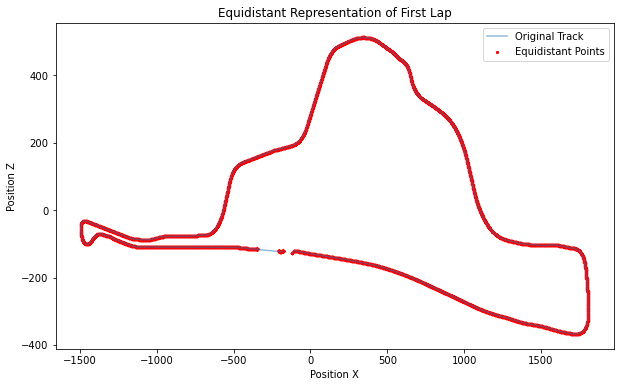

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter the data for the first lap
first_lap_data = df[df['lap_number'] == 0].copy()

# Step 2: Calculate stepwise distances (Euclidean distance between consecutive points)
first_lap_data['distance_step'] = np.sqrt(
    (first_lap_data['pos_x'].diff())**2 +
    (first_lap_data['pos_y'].diff())**2 +
    (first_lap_data['pos_z'].diff())**2
).fillna(0)

# Step 3: Ensure cumulative distance is unique by dropping duplicates
first_lap_data = first_lap_data.drop_duplicates(subset='cumulative_distance')

# Step 4 & 5: Use reindex with the nearest method
equidistant_samples = first_lap_data.set_index('cumulative_distance').reindex(
    equidistant_distances, method='nearest'
).reset_index()

# Step 6: Rename columns for clarity
equidistant_samples = equidistant_samples[['pos_x', 'pos_y', 'pos_z', 'cumulative_distance']]

# Step 7: Save the equidistant representation to a CSV
equidistant_samples.to_csv('Solution_first_lap_equidistant.csv', index=False)

# Step 8: Plot original vs equidistant points for validation
plt.figure(figsize=(10, 6))
plt.plot(first_lap_data['pos_x'], first_lap_data['pos_z'], label='Original Track', alpha=0.5)
plt.scatter(equidistant_samples['pos_x'], equidistant_samples['pos_z'], color='red', s=5, label='Equidistant Points')
plt.xlabel('Position X')
plt.ylabel('Position Z')
plt.title('Equidistant Representation of First Lap')
plt.legend()
plt.show()


Data after removing consecutive duplicates: 11839 rows


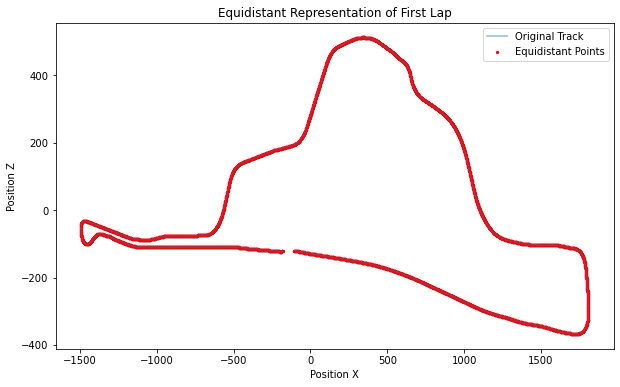

         pos_x      pos_y       pos_z
0  -106.423416 -19.977818 -120.187190
1  -105.428567 -19.978952 -120.260321
2  -104.431203 -19.979696 -120.332869
3  -103.433764 -19.979906 -120.404394
4  -102.436272 -19.979717 -120.475168
5  -101.438772 -19.979794 -120.545839
6  -100.441274 -19.979516 -120.616524
7   -99.443752 -19.979444 -120.686888
8   -98.446224 -19.978970 -120.757147
9   -97.448683 -19.977845 -120.827229
10  -96.451157 -19.976193 -120.897504
11  -95.453691 -19.975174 -120.968648
12  -94.456289 -19.973854 -121.040664
13  -93.458957 -19.971397 -121.113619
14  -92.461673 -19.968854 -121.187229
15  -91.464434 -19.966487 -121.261458
16  -90.467245 -19.964249 -121.336341
17  -89.470117 -19.962037 -121.412045
18  -88.473077 -19.960031 -121.488901
19  -87.476157 -19.958453 -121.567318


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter the data for the first lap
first_lap_data = df[df['lap_number'] == 0].copy()

# Step 2: Remove consecutive rows with identical position values (consecutive duplicates)
first_lap_data = first_lap_data.loc[
    ~(first_lap_data[['pos_x', 'pos_y', 'pos_z']].diff().fillna(0) == 0).all(axis=1)
].reset_index(drop=True)

print(f"Data after removing consecutive duplicates: {len(first_lap_data)} rows")

# Step 3: Calculate stepwise distances (Euclidean distance between consecutive points)
first_lap_data['distance_step'] = np.sqrt(
    (first_lap_data['pos_x'].diff())**2 +
    (first_lap_data['pos_y'].diff())**2 +
    (first_lap_data['pos_z'].diff())**2
).fillna(0)

# Step 4: Calculate cumulative distance
first_lap_data['cumulative_distance'] = first_lap_data['distance_step'].cumsum()

# Step 5: Choose equidistant intervals (e.g., every 1 meter along the cumulative distance)
equidistant_distances = np.arange(0, first_lap_data['cumulative_distance'].max(), step=1)

# Step 6: Perform equidistant sampling using interpolation
pos_x_interp = np.interp(equidistant_distances, first_lap_data['cumulative_distance'], first_lap_data['pos_x'])
pos_y_interp = np.interp(equidistant_distances, first_lap_data['cumulative_distance'], first_lap_data['pos_y'])
pos_z_interp = np.interp(equidistant_distances, first_lap_data['cumulative_distance'], first_lap_data['pos_z'])

# Step 7: Create a DataFrame for equidistant samples
equidistant_samples = pd.DataFrame({
    # 'cumulative_distance': equidistant_distances,
    'pos_x': pos_x_interp,
    'pos_y': pos_y_interp,
    'pos_z': pos_z_interp
})

# Step 8: Save the equidistant representation to a CSV file
equidistant_samples.to_csv('Solution_first_lap_equidistant.csv', index=False)

# Step 9: Plot original vs equidistant points for validation
plt.figure(figsize=(10, 6))
plt.plot(first_lap_data['pos_x'], first_lap_data['pos_z'], label='Original Track', alpha=0.5)
plt.scatter(equidistant_samples['pos_x'], equidistant_samples['pos_z'], color='red', s=5, label='Equidistant Points')
plt.xlabel('Position X')
plt.ylabel('Position Z')
plt.title('Equidistant Representation of First Lap')
plt.legend()
plt.show()

# Optional: Print first few rows to verify the equidistant samples
print(equidistant_samples.head(20))


In [80]:
last_distance = first_lap_data['cumulative_distance'].iloc[-1]
last_distance

7380.304850545578

In [81]:
# row where the abs(df["cumulative_distance"] -first_lap_data['cumulative_distance'].iloc[-1]) is less than 10  
print(df[abs(df["cumulative_distance"] -last_distance) < 10].iloc[0]["timestamp"])

0 days 00:03:47.669214962


In [82]:
#create a regression model with scikit learn for next pos_x pos_y and pos_z for next complete lap
from sklearn.linear_model import LinearRegression

# Filter data for the first lap
first_lap = df[df['lap_number'] == 0].copy()

# Sort by cumulative distance
first_lap = first_lap.sort_values('cumulative_distance')

# Extract features (cumulative distance) and targets (pos_x, pos_y, pos_z)
X = first_lap[['cumulative_distance']].values
y_x = first_lap['pos_x'].values
y_y = first_lap['pos_y'].values
y_z = first_lap['pos_z'].values

# Create linear regression models for pos_x, pos_y, and pos_z
model_x = LinearRegression()
model_y = LinearRegression()
model_z = LinearRegression()

# Fit the models
model_x.fit(X, y_x)
model_y.fit(X, y_y)
model_z.fit(X, y_z)

# Predict the next position for a new cumulative distance
next_distance = last_distance + 1  # Increment by 1 for the next point
next_pos_x = model_x.predict([[next_distance]])[0]
next_pos_y = model_y.predict([[next_distance]])[0]
next_pos_z = model_z.predict([[next_distance]])[0]

# Display the predicted position
print(f"Predicted Position (X, Y, Z) at distance {next_distance}: ({next_pos_x:.2f}, {next_pos_y:.2f}, {next_pos_z:.2f})")


Predicted Position (X, Y, Z) at distance 7381.304850545578: (-710.69, -2.56, 30.71)


In [89]:
df.columns


Index(['tick', 'timestamp', 'speed_kmh', 'pos_x', 'pos_y', 'pos_z', 'throttle',
       'brake', 'rpm', 'fuel', 'fuel capacity', 'packet id', 'curr',
       'gear_curr', 'gear_sugg', 'charge_rem', 'battery_max', 'boost',
       'tyre_diam_fl', 'tyre_diam_fr', 'tyre_diam_rl', 'tyre_diam_rr',
       'tyre_speed_fl', 'tyre_speed_fr', 'tyre_speed_rl', 'tyre_speed_rr',
       'time_of_day_ms', 'laps_total', 'positions_curr', 'positions_total',
       'rpm_warning', 'rpm_rev_limiter', 'speed_top', 'clutch',
       'clutch_engaged', 'rpm_after_clutch', 'oil_temp', 'water_temp',
       'oil_pressure', 'ride_height', 'tyre_temp_fl', 'tyre_temp_fr',
       'suspension_fl', 'suspension_fr', 'tyre_temp_rl', 'tyre_temp_rr',
       'suspension_rl', 'suspension_rr', 'gear_1', 'gear_2', 'gear_3',
       'gear_4', 'gear_5', 'gear_6', 'gear_7', 'gear_8', 'gear_9', 'vel_x',
       'vel_y', 'vel_z', 'rot_x', 'rot_y', 'rot_z', 'vel_ang_x', 'vel_ang_y',
       'vel_ang_z', 'rotx_x', 'unknown_bits_0', 'unknow

In [102]:
# Ensure column names are consistent and avoid duplicates
cleaned_df = df[["pos_x", "pos_y", "pos_z", "cumulative_distance","distance_to_start", "curr", "throttle", "brake", "charge_rem", "fuel", "rpm", "speed_kmh"]].copy()

# Create new columns for next positions
cleaned_df.loc[:, "next_pos_x"] = cleaned_df["pos_x"].shift(-1)
cleaned_df.loc[:, "next_pos_y"] = cleaned_df["pos_y"].shift(-1)
cleaned_df.loc[:, "next_pos_z"] = cleaned_df["pos_z"].shift(-1)

# Calculate rolling means
cleaned_df.loc[:, "pos_x_last_20_mean"] = cleaned_df["pos_x"].rolling(window=20).mean()
cleaned_df.loc[:, "pos_y_last_20_mean"] = cleaned_df["pos_y"].rolling(window=20).mean()
cleaned_df.loc[:, "pos_z_last_20_mean"] = cleaned_df["pos_z"].rolling(window=20).mean()

# Drop rows with NaN values
cleaned_df = cleaned_df.dropna()

# Create new columns for next cumulative distance and rolling means
cleaned_df.loc[:, "next_cumulative_distance"] = cleaned_df["cumulative_distance"].shift(-1)
cleaned_df.loc[:, "curr_last_20_mean"] = cleaned_df["curr"].rolling(window=20).mean()
cleaned_df.loc[:, "throttle_last_20_mean"] = cleaned_df["throttle"].rolling(window=20).mean()
cleaned_df.loc[:, "brake_last_20_mean"] = cleaned_df["brake"].rolling(window=20).mean()
cleaned_df.loc[:, "charge_rem_last_20_mean"] = cleaned_df["charge_rem"].rolling(window=20).mean()
cleaned_df.loc[:, "fuel_last_20_mean"] = cleaned_df["fuel"].rolling(window=20).mean()
cleaned_df.loc[:, "rpm_last_20_mean"] = cleaned_df["rpm"].rolling(window=20).mean()
cleaned_df.loc[:, "speed_kmh_last_20_mean"] = cleaned_df["speed_kmh"].rolling(window=20).mean()

# Drop rows with NaN values again
cleaned_df = cleaned_df.dropna()

# Create new columns for next values
cleaned_df.loc[:, "next_curr"] = cleaned_df["curr"].shift(-1)
cleaned_df.loc[:, "next_throttle"] = cleaned_df["throttle"].shift(-1)
cleaned_df.loc[:, "next_brake"] = cleaned_df["brake"].shift(-1)
cleaned_df.loc[:, "next_charge_rem"] = cleaned_df["charge_rem"].shift(-1)
cleaned_df.loc[:, "next_fuel"] = cleaned_df["fuel"].shift(-1)
cleaned_df.loc[:, "next_rpm"] = cleaned_df["rpm"].shift(-1)
cleaned_df.loc[:, "next_speed_kmh"] = cleaned_df["speed_kmh"].shift(-1)

# Drop rows with NaN values again
cleaned_df = cleaned_df.dropna()

cleaned_df

,pos_x,pos_y,pos_z,cumulative_distance,curr,throttle,brake,charge_rem,fuel,rpm,...,fuel_last_20_mean,rpm_last_20_mean,speed_kmh_last_20_mean,next_curr,next_throttle,next_brake,next_charge_rem,next_fuel,next_rpm,next_speed_kmh
38,-121.31121,-19.996595,-128.27039,0.000000,0,0,0,99.965920,99.965920,1546.0,...,99.965992,1540.45,0.000000,0.0,0.0,0.0,99.965910,99.965910,1546.0,0.00000
39,-121.31121,-19.996595,-128.27039,0.000000,0,0,0,99.965910,99.965910,1546.0,...,99.965985,1541.50,0.000000,0.0,0.0,0.0,99.965904,99.965904,1543.0,0.00000
40,-121.31121,-19.996595,-128.27039,0.000000,0,0,0,99.965904,99.965904,1543.0,...,99.965977,1542.30,0.000000,0.0,0.0,0.0,99.965900,99.965900,1541.0,0.00000
41,-121.31121,-19.996595,-128.27039,0.000000,0,0,0,99.965900,99.965900,1541.0,...,99.965969,1542.85,0.000000,0.0,0.0,0.0,99.965890,99.965890,1540.0,0.00000
42,-121.31121,-19.996595,-128.27039,0.000000,0,0,0,99.965890,99.965890,1540.0,...,99.965962,1543.20,0.000000,0.0,0.0,0.0,99.965880,99.965880,1538.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53104,214.13310,-19.273314,-141.23705,37128.130636,6,0,0,68.782960,68.782960,5162.0,...,68.782960,5196.10,236.470448,6.0,0.0,0.0,68.782960,68.782960,5158.0,234.71432
53105,215.21400,-19.240147,-141.35538,37129.218500,6,0,0,68.782960,68.782960,5158.0,...,68.782960,5192.55,236.303919,6.0,0.0,0.0,68.782960,68.782960,5154.0,234.55070
53106,216.29407,-19.206482,-141.47382,37130.305566,6,0,0,68.782960,68.782960,5154.0,...,68.782960,5188.95,236.137324,6.0,0.0,0.0,68.782960,68.782960,5150.0,234.38577
53107,217.37340,-19.172590,-141.59235,37131.391914,6,0,0,68.782960,68.782960,5150.0,...,68.782960,5185.35,235.970733,6.0,0.0,0.0,68.782960,68.782960,5146.0,234.22214


In [107]:
cleaned_df.columns



Index(['pos_x', 'pos_y', 'pos_z', 'cumulative_distance', 'curr', 'throttle',
       'brake', 'charge_rem', 'fuel', 'rpm', 'speed_kmh', 'next_pos_x',
       'next_pos_y', 'next_pos_z', 'pos_x_last_20_mean', 'pos_y_last_20_mean',
       'pos_z_last_20_mean', 'next_cumulative_distance', 'curr_last_20_mean',
       'throttle_last_20_mean', 'brake_last_20_mean',
       'charge_rem_last_20_mean', 'fuel_last_20_mean', 'rpm_last_20_mean',
       'speed_kmh_last_20_mean', 'next_curr', 'next_throttle', 'next_brake',
       'next_charge_rem', 'next_fuel', 'next_rpm', 'next_speed_kmh'],
      dtype='object')

<AxesSubplot:>

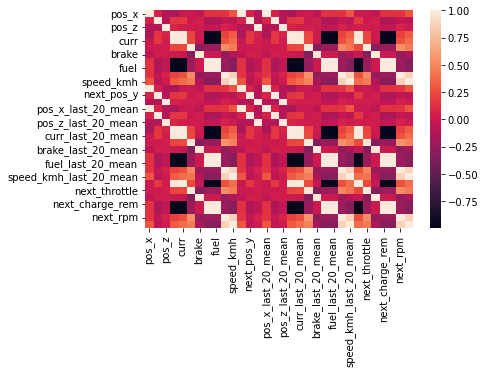

In [96]:
import seaborn as sns

<AxesSubplot:>

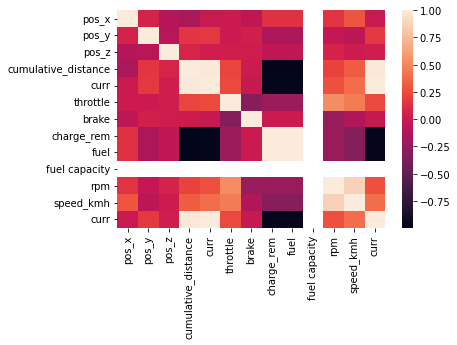

In [97]:
sns.heatmap(cleaned_df.corr())